# Habit persistence

## Overview

__This notebook displays three models and solutions with capital and endogenously determined long-run risk.  The models are considered in each of the three sections of this notebook and include:__

__1. Adjustment cost__

__2. Permanent income__

__3. Habit persistance__

__The first is an AK model with adjustment costs inspired in part by Eberly and Wong but includes a persistence process for technology.  The second is a version of Friedman's permanent income model, and the third one extends this to include habit persistence preferences motivated by the work of Hansen, Sargent Tallarini.__

*This Notebook shows the solution strategy of the habit persistence model with HST's specification, addressed in "Robust social planner with a single capital stock: notes" ("notes" for reference). The notebook has two sections:*

*1. Consumption responses for the permanent and transitory shock processes for habit persistent preferences*

*2. Robustnes*

*Note: To use this notebook, one needs to install `sympy`,  a Python library for symbolic mathematics that can solve system of equations analytically. We use `sympy` here to solve the system dynamics of the habit persistence model. For more information about `sympy`, visit http://docs.sympy.org/latest/tutorial/index.html.*

In [1]:
# Toggle on/off the raw code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to switch on/off the raw code"></form>''')

## Section 3: Habit Persistance

### Section 3.1: Consumption responses under habit persistence

In this section, we solve the system dynamics of the habit persistence model and plot the consumption responses. First, we setup the parameters, shocks and figure format, and import functions from the module `habit_persistence_code`. The parameters follow Section 2 of the chapter.

In [2]:
#==============================================================================
# Setup
#==============================================================================
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from habit_persistence_code2 import *

To compute consumption responses under habit persistence, we essentially conduct the following steps:

1. Calculate parameters and Steady State Values
2. Solve $C^{1}_{t}$ and $U^{1}_{t}$ in terms of $Z^{1}_{t}$ and $Z^{1}_{t+1}$
3. Solve for matrices $\mathbb{L}$ and $\mathbb{J}$ (in this notebook I use $\mathbb{L} = I$ and solve for $\mathbb{J}$)
4. Compute $\mathbb{N}_{11}$ and $\mathbb{N}_{12}$
5. Compute the stable dynamic matrix $\mathbb{A}$
6. Perform the two checks: (1) the matrix multiplication is zero (2) eigenvalues of $\mathbb{A}$ coincide with the weakly stable eigenvalues
7. Add the shocks back to the $X$ evolution equation
8. Compute the consumption response process {$C^{1}_{t} + Y^{1}_{t}$}.

More detailed formulas and instructions can be found in "Solution strategy" section in "notes". Here we provide some equations for reference in the codes:

\begin{equation}
\tag{1}
\label{1}
K^{1}_{t+1} = \exp(\rho - \nu) K^{1}_{t} - \exp(-\nu) C^{1}_{t}
\end{equation}

\begin{equation}
\tag{2}
\label{2}
H^{1}_{t+1} = \exp(-\psi - \nu) H^{1}_{t} - [1 - \exp(-\nu - \psi)] C^{1}_{t} - Y_{t+1} + Y_{t}
\end{equation}

\begin{equation}
\tag{3}
\label{3}
U^{1}_{t} = (1-\alpha) \exp[(\eta - 1)(\bar{u} - \bar{c})] C^{1}_{t} + \alpha \exp[(\eta - 1)(\bar{u} - \bar{h})] H^{1}_{t}
\end{equation}

\begin{equation}
\tag{4}
\label{4}
\exp(-\delta - \psi - \nu + \overline{mh})E[MH^{1}_{t+1} + Y^{1}_{t} - Y^{1}_{t+1} | \mathcal{F}_{t}] = \exp(\overline{mh})MH^{1}_{t} - \alpha \exp[(\eta - 1) \bar{u} - \eta \bar{h}] [(\eta - 1) U^{1}_{t} - \eta H^{1}_{t}]
\end{equation}

\begin{equation}
\tag{5}
\label{5}
(1 - \alpha) \exp[(\eta - 1) \bar{u} - \eta \bar{c}] [(\eta - 1) U^{1}_{t} - \eta C^{1}_{t}] = \exp(-\delta - \nu) E\{\exp(\overline{mk}) MK^{1}_{t+1} - [1 - \exp(-\psi)] \exp(\overline{mh}) MH^{1}_{t+1} | \mathcal{F}_{t}\} + \exp(-\delta - \nu) \{\exp(\overline{mk}) - [1 - \exp(-\psi)] \exp(\overline{mh})\} E(Y^{1}_{t} - Y^{1}_{t+1} | \mathcal{F}_{t})
\end{equation}

\begin{equation}
\tag{6}
\label{6}
\exp(-\delta + \rho - \nu) E[MK^{1}_{t+1} + Y^{1}_{t} - Y^{1}_{t+1} | \mathcal{F}_{t}] = MK^{1}_{t}
\end{equation}

We construct two functions to execute the above steps:
- (for steps 1 through 6) `solve_habit_persistence` 
- (for steps 7 and 8) `habit_persistence_consumption_path`

We first solve the habit persistence model with function `solve_habit_persistence`, and then we calculate the consumption responses by inputting the model solution into function `habit_persistence_consumption_path`. I will later test to combine these two functions with the default parameters into a `class` object. For now we just keep the functions separately.

The parameters that can be changed are in `solve_habit_persistence`:

- $\alpha$: share parameter
- $\psi$: depreciation rate, $0\leq\exp(-\psi)<1$
- $\eta$: elasticity of substitution.

The example below provides a standard procedure of how to solve, compute and plot the consumption responses with our choice of parameters. In this example, we set $\alpha = 0.5$, $\psi = 0.3$, and $\eta = 2$. The function `create_fig` to create the plot format for the impulse responses, in which we can control the subplots, size and the time horizon on the x-axis.

In many cases, we would like to plot out the consumption responses given our choices of one parameter while holding the other two parameters fixed. Here we will create empty lists to store the consumption response paths for each choice of the parameter, and then use a `for` loop to plot out each choice. The examples below are the figures we have on "notes":

- Consumption responses for $\alpha = .1$, $\epsilon = 10, 25, 50, 100$, $\chi = .4$ (80 periods)

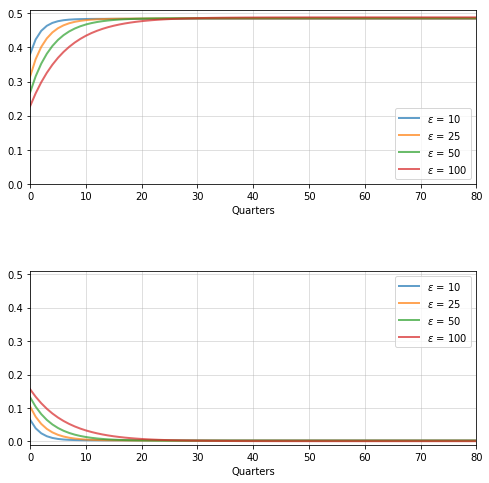

In [3]:
#==============================================================================
# Consumption responses for alpha = .1; epsilon = 10, 25, 50, 100; chi = .4
#==============================================================================
# Set time 
T = 80 + 1

C1Y1_list = []
C2Y2_list = []

epsilon_list = [10, 25, 50, 100]


for e in epsilon_list:
        
    J, A, N, Ut = solve_habit_persistence(0.1, -np.log(0.4), e)
    
    # Append consumption responses to list
    CYs, Ys = habit_persistence_consumption_path(A, N, T=T)
    C1Y1, C2Y2 = CYs
    
    C1Y1_list.append(C1Y1)
    C2Y2_list.append(C2Y2)  
    
    # Compute uncertainty price
    Sv = get_Sv(J, A, N, Ut)
    SvBFy = get_SvBFy(Sv) * 100
    SvBFy = [float('%.3g' % x) for x in SvBFy]

##== Plot the graphs for the impulse reponses ==##
# Define plot attributes
p_args = {'lw': 2, 'alpha': 0.7}

## Impulse response plots for consumption
fig, axes = create_fig(2,1,X=80) # 80 periods

ax = axes[0]
ax.set_ylim(0., 0.51)
for n, C1Y1 in enumerate(C1Y1_list):
    ax.plot(list(range(T)), C1Y1, **p_args, 
            label=r'$\epsilon$ = {}'.format(epsilon_list[n]))
    ax.legend(loc='lower right')

ax = axes[1]
ax.set_ylim(-0.01, 0.51)
for n, C2Y2 in enumerate(C2Y2_list):
    ax.plot(list(range(T)), C2Y2, **p_args, 
            label=r'$\epsilon$ = {}'.format(epsilon_list[n]))
    ax.legend(loc='upper right')

plt.show()

In [4]:
# Export the figure
fig.savefig('../Figures/habit_persistence_impulse_response_varyepsilon.pdf')

- Consumption responses for $\alpha = .1, .3, .5, .7, .9$, $\epsilon = 50$, $\chi = .4$ (80 periods)

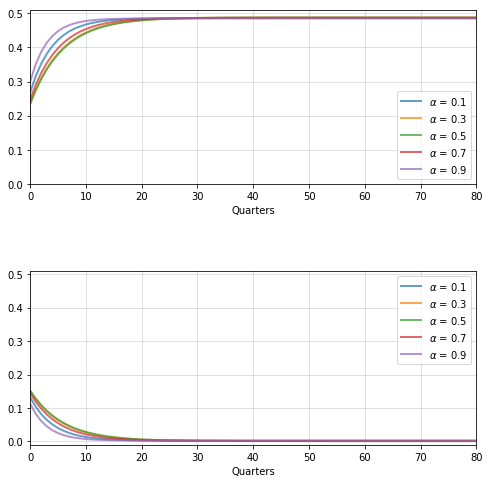

In [5]:
#==============================================================================
# Consumption responses for alpha = .1, .3, .5, .7, .9; epsilon = 50; chi = .4
#==============================================================================
# Set time 
T = 80 + 1

C1Y1_list = []
C2Y2_list = []

alpha_list = [.1, .3, .5, .7, .9]


for a in alpha_list:
        
    J, A, N, Ut = solve_habit_persistence(a, -np.log(0.4), 50)
        
    # Append consumption responses to list
    CYs, Ys = habit_persistence_consumption_path(A, N, T=T)
    C1Y1, C2Y2 = CYs
    
    C1Y1_list.append(C1Y1)
    C2Y2_list.append(C2Y2)  

##== Plot the graphs for the impulse reponses ==##
# Define plot attributes
p_args = {'lw': 2, 'alpha': 0.7}

## Impulse response plots for consumption
fig, axes = create_fig(2,1,X=80) # 80 periods

ax = axes[0]
ax.set_ylim(0., 0.51)
for n, C1Y1 in enumerate(C1Y1_list):
    ax.plot(list(range(T)), C1Y1, **p_args, 
            label=r'$\alpha$ = {}'.format(alpha_list[n]))
    ax.legend(loc='lower right')

ax = axes[1]
ax.set_ylim(-0.01, 0.51)
for n, C2Y2 in enumerate(C2Y2_list):
    ax.plot(list(range(T)), C2Y2, **p_args, 
            label=r'$\alpha$ = {}'.format(alpha_list[n]))
    ax.legend(loc='upper right')

plt.show()

In [6]:
# Export the figure
fig.savefig('../Figures/habit_persistence_impulse_response_varyalpha.pdf')

- Consumption responses for $\alpha = .1$, $\epsilon = 50$, $\chi = .6, .8, .9, .95$ (80 periods)

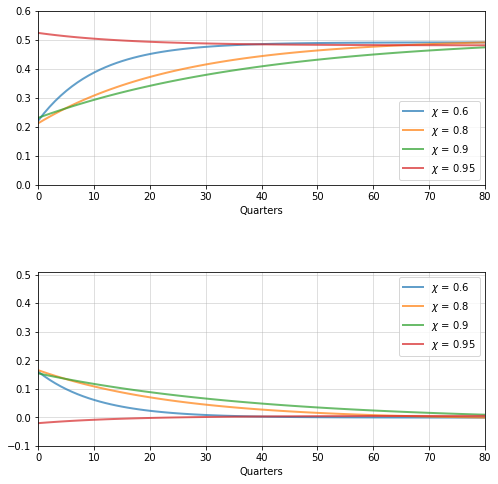

In [7]:
#==============================================================================
# Consumption responses for alpha = .1; epsilon = 100; chi = .4, .8, 1.6, 2.4
#==============================================================================
# Set time 
T = 80 + 1

C1Y1_list = []
C2Y2_list = []

chi_list = [.6, .8, .9, .95]


for c in chi_list:
        
    J, A, N, Ut = solve_habit_persistence(0.1, -np.log(c), 100)
    
    # Append consumption responses to list
    CYs, Ys = habit_persistence_consumption_path(A, N, T=T)
    C1Y1, C2Y2 = CYs
    
    C1Y1_list.append(C1Y1)
    C2Y2_list.append(C2Y2)  

##== Plot the graphs for the impulse reponses ==##
# Define plot attributes
p_args = {'lw': 2, 'alpha': 0.7}

## Impulse response plots for consumption
fig, axes = create_fig(2,1,X=80)

ax = axes[0]
ax.set_ylim(0., 0.6)
for n, C1Y1 in enumerate(C1Y1_list):
    ax.plot(list(range(T)), C1Y1, **p_args,  
            label=r'$\chi$ = {}'.format(chi_list[n]))
    ax.legend(loc='lower right')

ax = axes[1]
ax.set_ylim(-0.1, 0.51)
for n, C2Y2 in enumerate(C2Y2_list):
    ax.plot(list(range(T)), C2Y2, **p_args, 
            label=r'$\chi$ = {}'.format(chi_list[n]))
    ax.legend(loc='upper right')

plt.show()

In [8]:
# Export the figure
fig.savefig('../Figures/habit_persistence_impulse_response_varychi.pdf')

### Section 3.2: Robustness

Next we add in a concern about robustness as in Hansen et al. (1999). Represent:

\begin{equation}
Y^{1}_{t+1} - Y^{1}_{t} = \mathbb{S}_y \cdot X_{t} + \mathbb{F}_y \cdot W_{t+1}
\end{equation}

\begin{equation}
U^{1}_{t} = 
\mathbb{S}_{u} \cdot 
\begin{bmatrix}
K^{1}_{t} \\
H^{1}_{t} \\
X_{t}
\end{bmatrix}
\end{equation}

\begin{equation}
V^{1}_{t} - Y^{1}_{t} = 
\mathbb{S}_{v} \cdot 
\begin{bmatrix}
K^{1}_{t} \\
H^{1}_{t} \\
X_{t}
\end{bmatrix}
+ s_{v}
\end{equation}

where $\mathbb{S}_{u}$ comes from the model solution using `solve_habit_persistence`. Specifically, we do the following:

1. Get $U^{1}_{t}$ from the model solution and express it in terms of $Z$
2. Express the co-state expressions $MK^{1}_{t}$ and $MH^{1}_{t}$ in $U^{1}_{t}$ in terms of the states $K^{1}_{t}$, $H^{1}_{t}$, $X_{t}$
3. Collecting terms to get $U^{1}_{t}$ in terms of $K^{1}_{t}$, $H^{1}_{t}$, $X_{t}$

Next, we compute $\mathbb{S}_{v}$ as in Hansen et al. (2008)

\begin{equation}
(\mathbb{S}_{v})' = 
[1 - \exp(-\delta)] (\mathbb{S}_{u})' + 
\exp(-\delta) [(\mathbb{S}_{v})'\mathbb{A} + 
\begin{bmatrix}
0 & 0 & (\mathbb{S}_y)'
\end{bmatrix}]
\end{equation}

The above procedures can be done through the function `get_Sv`. The function uses the inputs from `solve_habit_persistence` to solve for $\mathbb{S}_{v}$.

We also solve $s_{v}$, 

\begin{equation}
s_{v} = \exp(-\delta)[s_{v} - \frac{\xi}{2}|(\mathbb{S}_{v})'\mathbb{B} + \mathbb{S}_{y})'\mathbb{B}_x|^{2}]
\end{equation}

and the uncertainty price vector 

\begin{equation}
(\mathbb{S}_{v})'\mathbb{B} + F_{y}
\end{equation}

with functions `solve_sv` and `get_SvBFy` respectively. 
Now, we test the example that we used in "notes": $(\alpha, \eta, \psi) = (.1, 100, 1.6)$:

## References

Hansen, Lars Peter and Thomas J. Sargent. 2008. *Robustness*. Princeton, New Jersey:
Princeton University Press.

Hansen, Lars Peter, William Roberds, and Thomas J. Sargent. 1991. Time Series Im-
plications of Present Value Budget Balance and of Martingale Models of Consumption
and Taxes. *In Rational Expectations Econometrics*, edited by Lars Peter Hansen and
Thomas J. Sargent, chap. 5. Boulder, Colorado: Westview Press.

Hansen, Lars Peter, Thomas Sargent, and Thomas Tallarini. 1999. Robust Permanent
Income and Pricing. *Review of Economic Studies* 66 (4):873-907.

Hansen, Lars Peter, John C. Heaton, and Nan Li. 2008. Consumption Strikes Back?:
Measuring Long Run Risk. *Journal of Political Economy*.